## Imports

In [1]:
import scipy.io, random
import numpy as np
from utils import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from scipy import stats

## Utils

In [2]:
def plot_forecast(source, prediction, nrow=5, ncol=5, from_=2800, to_=None, figsize=(10,8)):
    n = source.shape[0]
    idx = list(range(n))
    fig, axs = plt.subplots(nrow, ncol, figsize=figsize, sharex=True)
    if to_ is None:
        to_ = source.shape[1]
    i = 0
    for r in range(nrow):
        for c in range(ncol):
            axs[r,c].plot(range(from_, to_), source[idx[i], from_:to_], c='b', label='Real values')
            axs[r,c].plot(range(from_, to_), prediction[idx[i], from_:to_], c='r', label='Forecasts')
            axs[r,c].grid()
            i += 1
            
    fig.tight_layout()
    handles, labels = fig.axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, ncol=2, fontsize='large', loc='upper center', bbox_to_anchor=(0.25, 0.55, 0.5, 0.5))
    plt.setp(axs[-1, :], xlabel='Time')
    plt.show()

In [3]:
def read_data_from_csv(data_path):
    df = pd.read_csv(data_path)
    X = df.iloc[:, 1:].to_numpy()
    return X

In [4]:
def plot_sf(d, F, F_hat, nrow=5, ncol=5, to_=None, figsize=(10,8), step=10):
    fig, axs = plt.subplots(nrow, ncol, figsize=figsize, sharex=True)
    if to_ is None:
        to_ = F.shape[0]
    i = 0
    for r in range(nrow):
        for c in range(ncol):
            axs[r,c].scatter(d[:to_], F[i, :to_,], c='b', label='Actual SF')
            axs[r,c].scatter(d[:to_], F_hat[i, :to_,], c='r', label='Estimated SF')
            axs[r,c].title.set_text(f'Time = {i *step}')
            axs[r,c].grid()
            i += 1
            
    fig.tight_layout()
#     handles, labels = fig.axes[0].get_legend_handles_labels()
#     fig.legend(handles, labels, ncol=2, fontsize='large', loc='upper center', bbox_to_anchor=(0.25, 0.55, 0.5, 0.5))
    plt.setp(axs[-1, :], xlabel='Distance')
    plt.show()

In [ ]:
import matplotlib.colors as mcolors
colors = [v for k, v in mcolors.TABLEAU_COLORS.items()]

## Init

In [21]:
ids, d = load_pickle('data/sample.pickle')

In [147]:
data = np.load('data/air/data.npy')
# data = read_data_from_csv('data/quad_sim/csv/s5.csv')
# data_std = scale(data,0,1)

In [ ]:
#  Check data pattern
i = 5
plt.figure(figsize=(20,10))
plt.plot(data[i, :300])
# plt.plot(data_std[i, :])

# Stationary

## 1. Forecasting

In [ ]:
sim = load_pickle('output/st_sim.pickle')

In [ ]:
sim[0].shape, sim[1].shape, sim[2].shape

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(300,500), sim[0][10, -200:], c='b', label='Real Values')
plt.plot(range(300, 500), sim[1][10, -200:], c='r', label='Forecasts')
plt.xlabel('Time')
plt.legend(fontsize='medium', loc='upper left')
plt.title('Stationary Simulation')
plt.grid()
plt.show()

In [ ]:
plot_forecast(sim[0], sim[1], 6, 5, 300, 500, (16,7))

## 2. Shape Function

In [ ]:
F = np.log(d+1)

In [ ]:
l = 1000
plt.figure(figsize=(8,5))
plt.scatter(d[:l], F[:l, ], c='b', label='Actual SF')
plt.scatter(d[:l], sim[2][:l, 0], c='r', label='Estimated SF')
plt.legend()
plt.grid()
plt.xlabel('Distance')
plt.title('Stationary Simulation')
plt.show()

In [ ]:
plot_shape_function(d_norm, sim[2], None, 5, 5)

## 3. Multi-Step

In [ ]:
h1 = load_pickle('output/sim_h1.pickle')
h2 = load_pickle('output/sim_h5.pickle')

In [ ]:
ts = 200
fig, axs = plt.subplots(1, 2, figsize=(18,8))
axs[0].plot(h1[0][10, -ts:], c='b')
axs[0].plot(h1[1][10, -ts:], c='r')
axs[0].title.set_text('h = 1')

axs[1].plot(h2[0][10, -ts:], c='b')
axs[1].plot(h2[1][10, -ts:], c='r')
axs[].title.set_text('h = 5')
plt.show()

# Non-Stationary

In [22]:
def get_alphas(path):
    alphas = pd.read_csv(path)
    return alphas.iloc[:, 1:].to_numpy()

In [23]:
alphas = get_alphas('data/nst_sim/alphas.csv')

In [ ]:
# Quadratic
T = 500
F = []
for i in tqdm(range(100)):
    As = []
    alpha = alphas[i, :]
    for t in range(2, T + 1):
        alpha_1 = (1 - (t-1)/T)*alpha[0]+(t-1)/T*alpha[1]
        a = -(alpha_1 * d**2 - 400 * alpha_1 * d)
        As.append(a)
        
    a = (alpha[1] * d**2 - 400 * alpha[1] * d)
    As.append(a)
    F.append(As)
F = - np.array(F)

In [24]:
# Random
T = 500
n = 100
F = []
for i in tqdm(range(n)):
    As = []
    for t in range(T):
        alpha_1 = alphas[i, t]
#         a = - alpha_1 * np.log(d+1) 
        a = (alpha_1 * d**2 - 400 * alpha_1 * d)
        As.append(a)

    F.append(As)
F = np.array(F)

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 33.26it/s]


In [ ]:
np.save('data/nst_sim/F.npy', F)
# F = np.load('data/nst_sim/F.npy')

In [ ]:
F.shape

In [ ]:
plt.scatter(d, F[0, 10, :])

## 1. Forecasting

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(0,500), out[0][1, :], c='b', label='Real Values')
plt.plot(range(0, 500), out[1][1, :], c='r', label='Forecasts')
plt.xlabel('Time')
plt.legend(fontsize='medium', loc='upper left')
plt.title('Non-Stationary Simulation')
plt.grid()
plt.show()

In [ ]:
plot_forecast(out[0], out[1], 6, 5, 300, 500, (16,7))

## 2. Shape function

In [65]:
F_hats = []
for i in range(100):
    out = load_pickle(f'output/nst_sim/out{i}.pickle')
    f = out[2].transpose()
    F_hats.append(f)
F_hats = np.stack(F_hats)

In [66]:
idx = range(0, 300, 10)
F_agg = F[:, idx, :].mean(0)
F_hat_agg = F_hats[:, idx, :].mean(0)
F_agg.shape, F_hat_agg.shape

((30, 900), (30, 900))

In [30]:
F_hats.shape

(11, 500, 900)

In [ ]:
F_hats = []
for i in range(30):
    f = np.load(f'output/nst_sim/Fhat{i}.npy')
    F_hats.append(f)
F_hats = np.stack(F_hats)

In [54]:
out = load_pickle('output/test.pickle')
idx = range(0, 300, 10)
F_hat_agg =  out[2].transpose()[idx, ]
F_agg = F[:, idx, :].mean(0)
F_agg.shape, F_hat_agg.shape

((30, 900), (30, 900))

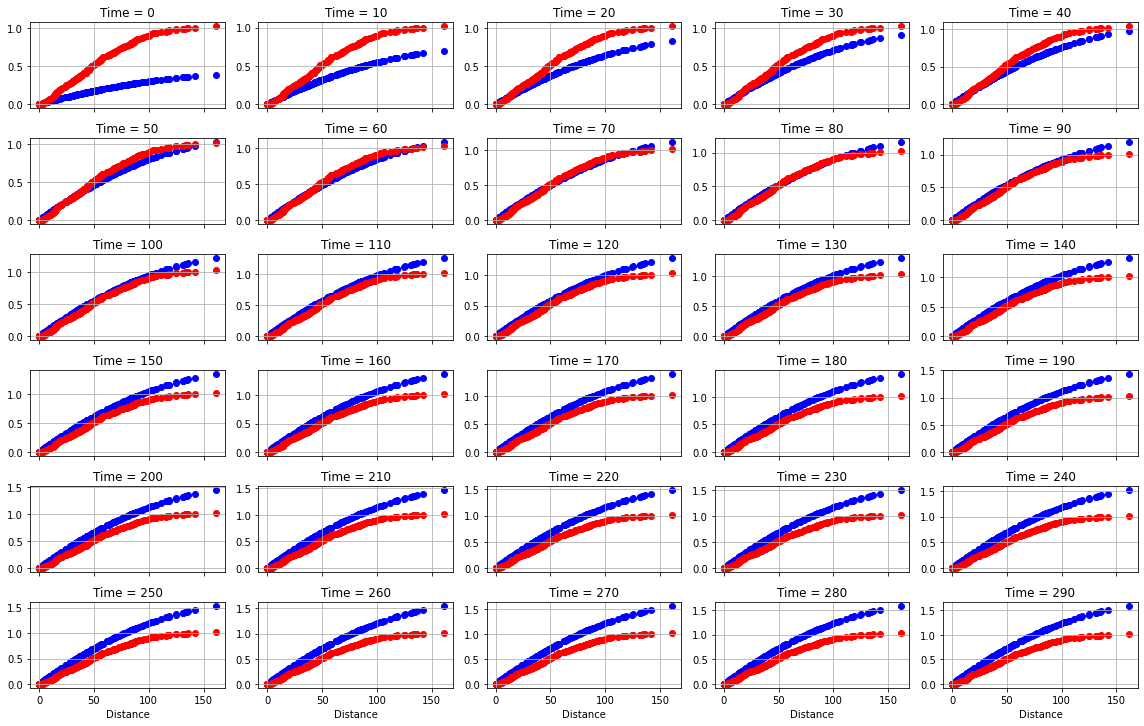

In [67]:
plot_sf(d, F_agg, F_hat_agg, 6, 5, 200, (16, 10))

$\hat{f}_t(d) = \alpha_t f(d)$

## 3. Multi-Step

In [ ]:
h1 = load_pickle('output/nst_sim_h1.pickle')
h2 = load_pickle('output/nst_sim_h10.pickle')


In [ ]:
ts = 500
fig, axs = plt.subplots(1, 2, figsize=(18,8))
axs[0].plot(h1[0][10, -ts:], c='b')
axs[0].plot(h1[1][10, -ts:], c='r')
axs[0].title.set_text('h = 1')

axs[1].plot(h2[0][10, -ts:], c='b')
axs[1].plot(h2[1][10, -ts:], c='r')
axs[1].title.set_text('h = 5')
plt.show()

# Baselines

In [ ]:
dataset = 'nst_sim'
horizon = 1
loc, n = 30, 500

In [ ]:
#  Scale data and horizon
# data = scale(data, 0.3, 0)

In [ ]:
x_offsets = np.sort(np.concatenate((np.arange(1-horizon, 1, 1),)))
y_offsets = np.sort(np.arange(1, 1+horizon, 1))
x_ids, y_ids = [], []
min_t = abs(min(x_offsets))
max_t = abs(n - abs(max(y_offsets)))  # Exclusive
for t in range(min_t, max_t):
    x_ids.extend(t + x_offsets)
    y_ids.extend(t + y_offsets)

In [ ]:
def aggregate(v, n=7320, h=20, loc=30):
    out = [np.zeros((1, loc)) for _ in range(n)]
    cnt = [np.ones((1, loc)) for _ in range(h)] + [np.zeros((1, loc)) for _ in range(n-h)]
    L = len(y_ids)
    for l in range(L):
        i = y_ids[l] 
        out[i] += v[l, :]
        cnt[i] += 1

    outs = np.concatenate(out)
    cnts = np.concatenate(cnt)
    return (outs/cnts).transpose()

In [ ]:
def load_outputs(path, n, h, loc):
    data = np.load(path)
    input, pred, label = data['input'], data['prediction'], data['truth']
    
    
    if 'DC-RNN' in path:
        pred, label = pred.swapaxes(0,1), label.swapaxes(0,1)
        
    predictions = aggregate(pred.reshape(-1, loc), n, h, loc)
    labels = aggregate(label.reshape(-1, loc), n, h, loc)
#     print(input.shape, pred.shape, label.shape, '//', predictions.shape, labels.shape)
    
    return predictions, labels

## Visualization

In [ ]:
def compute_metrics(name, p, l, horizon, size = None):
    if size:
        p = p[:, -size:]
        l = l[:, -size:]
    # Mean absolute error
    mae = (np.abs(p - l) / horizon).mean()

    # Mean Absolute Percentage Error
    smape = 2.0 * (np.abs(l-p)/(np.abs(l+1e-10)+np.abs(p+1e-10))).mean()

    # Root Mean Squared Error
    rmse = ((p - l)**2 / horizon).mean(-1)
    rmse = np.sqrt(rmse).mean()


    return mae, smape, rmse

In [ ]:
def get_result(i, horizon, collector):
    
    for name in names:
        p, l = load_outputs(f'{name}/data/{dataset}/output/preds{i}.npz', n, horizon, loc)
        out = compute_metrics(name, p, l, horizon)
        collector[name]['mae'].append(out[0])
        collector[name]['smape'].append(out[1])
        collector[name]['rmse'].append(out[2])
    return collector

In [ ]:
names = ['DC-RNN', 'FC-GAGA', 'GMAN', 'ConvLSTM']
collector = {}
for name in names:
    collector[name] = {"mae": [], "smape": [], "rmse": []}

In [ ]:
for i in tqdm(range(100)):
    collector = get_result(i, horizon, collector)    

In [ ]:
for name in names:
    means, stds = [], []
    for metric in ['mae', 'smape', 'rmse']:
        m = np.array(collector[name][metric]).mean()
        s = stats.sem(collector[name][metric])
        means.append(m)
        stds.append(s)
    print(f"{name} & {means[0]:.3f}\pm{stds[0]:.3f} & {means[1]:.3f}\pm{stds[1]:.3f} & {means[2]:.3f}\pm{stds[2]:.3f} \\\\")

In [ ]:
dataset = 'st_sim' if dataset == 'sim' else dataset
mae, smape, rmse = [], [], []
iter = range(100)
for i in tqdm(iter):
    p = np.load(f'output/{dataset}/preds{i}.npy')
    l = pd.read_csv(f'data/{dataset}/csv/s{i}.csv')
    l = l.iloc[:, 1:].to_numpy()
    a, b, c = compute_metrics('Shape function', p, l , horizon)
    mae.append(a)
    smape.append(b)
    rmse.append(c)

A = np.array(mae).mean(), stats.sem(mae)
B = np.array(smape).mean(), stats.sem(smape)
C = np.array(rmse).mean(), stats.sem(rmse)
print(f"Shape function & {A[0]:.3f}\pm{A[1]:.3f} & {B[0]:.3f}\pm{B[1]:.3f} & {C[0]:.3f}\pm{C[1]:.3f} \\\\")

## Mine /Air

In [43]:
ids, d = load_pickle('data/sample.pickle')

In [44]:
out = load_pickle('output/mine.pickle')

In [45]:
out[0].shape, out[1].shape, out[2].shape

((30, 4000), (30, 4000), (900, 3000))

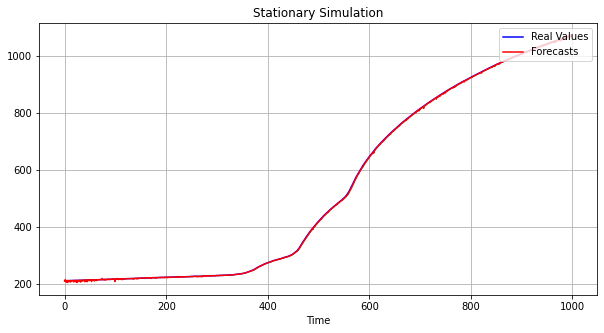

In [49]:
n = 20
plt.figure(figsize=(10,5))
plt.plot(out[0][n, 3000:], c='b', label='Real Values')
plt.plot(out[1][n, 3000:], c='r', label='Forecasts')
plt.xlabel('Time')
plt.legend(fontsize='medium', loc='upper right')
plt.title('Stationary Simulation')
plt.grid()
plt.show()

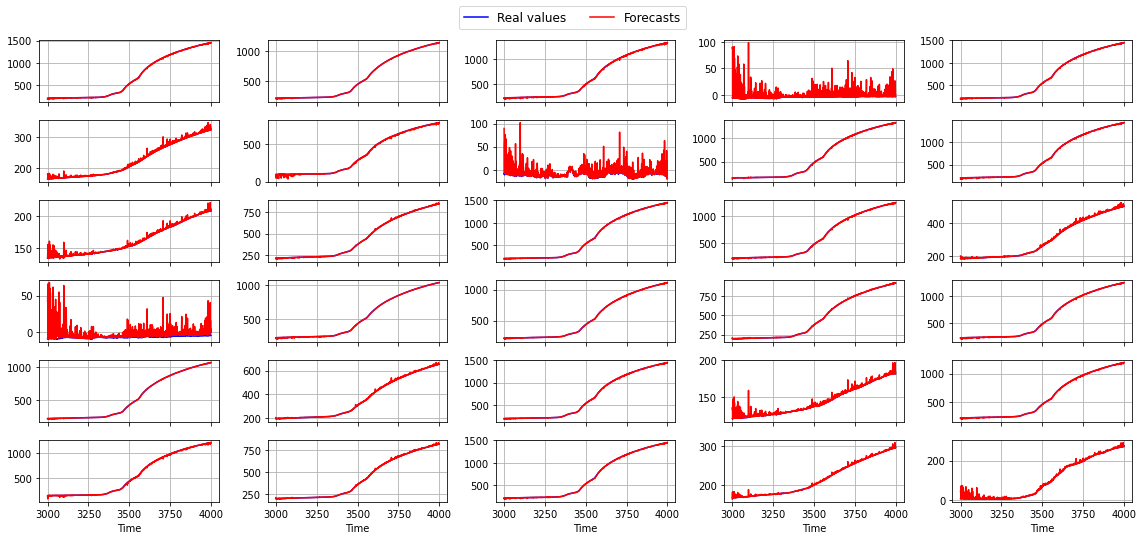

In [48]:
plot_forecast(out[0], out[1], 6, 5, 3000, 4000, (16,7))

In [12]:
out[2].shape

(900, 50)

In [50]:
idx = range(0, 50, 5)
f = out[2].transpose()[idx, ]
f.shape

(10, 900)

In [ ]:
plot_sf(d, f, f, 5, 2, 150, (16, 10), 100)